In [1]:
# based on tutorial:
# http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [2]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 16
learning_rate = 5e-2

In [4]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        p = 0.5
        if X[i - 3] == 1:
            p += 0.5
        if X[i - 8] == 1:
            p -= 0.25
        Y.append(0 if np.random.rand() > p else 1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [5]:
# Placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# RNN inputs
rnn_inputs = tf.one_hot(x, num_classes)

In [6]:
# Definition of rnn_cell
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

In [7]:
# predictions, loss and training step

# logits and prediction
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
                    [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

# losses and train step
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(total_loss)

In [8]:
# train the network
def train_network(num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))

            if verbose:
                print('\nEPOCH', idx)

            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses, total_loss, final_state, train_step],
                             feed_dict = {x: X, y: Y, init_state: training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print('average loss at step ', step, training_loss / 100)
                    training_losses.append(training_loss / 100)
                    training_loss = 0
    return training_losses


EPOCH 0
average loss at step  100 0.514726832807
average loss at step  200 0.479479955137
average loss at step  300 0.478914766908
average loss at step  400 0.476224729419

EPOCH 1
average loss at step  100 0.479103417695
average loss at step  200 0.470557211637
average loss at step  300 0.470292533636
average loss at step  400 0.468540433347

EPOCH 2
average loss at step  100 0.473941775858
average loss at step  200 0.46659508884
average loss at step  300 0.466111412346
average loss at step  400 0.466007062495

EPOCH 3
average loss at step  100 0.46924970299
average loss at step  200 0.464261369109
average loss at step  300 0.461247459948
average loss at step  400 0.462501668036

EPOCH 4
average loss at step  100 0.468705021739
average loss at step  200 0.461454636157
average loss at step  300 0.462808711529
average loss at step  400 0.461722369194


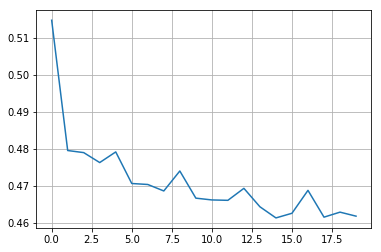

In [9]:
training_losses = train_network(num_epochs=5, num_steps=num_steps, state_size=state_size)
plt.plot(training_losses)
plt.grid()